In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy
from collections import defaultdict
import argparse
from matplotlib import pyplot as plt
import random, torch

random.seed(0) # Set seed for NumPy
np.random.seed(0) # Set seed for PyTorch (for both CPU and GPU)
torch.manual_seed(0)
if torch.cuda.is_available(): 
    torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train_df = pd.read_csv('train_dataset/metadata.csv')
test_df = pd.read_csv('test_dataset/metadata.csv')
val_df = pd.read_csv('validation_dataset/metadata.csv')

In [2]:
print(train_df['diagnosis'].value_counts())

diagnosis
nevus                         1205
melanoma                      1113
pigmented benign keratosis    1099
basal cell carcinoma           514
squamous cell carcinoma        197
vascular lesion                142
actinic keratosis              130
dermatofibroma                 115
Name: count, dtype: int64


In [3]:
class_mapping = {
    "actinic keratosis": 0,
    "basal cell carcinoma": 1,
    "dermatofibroma": 2,
    "melanoma": 3,
    "nevus": 4,
    "pigmented benign keratosis": 5,
    "squamous cell carcinoma": 6,
    "vascular lesion":7
}
class_mapping

{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'squamous cell carcinoma': 6,
 'vascular lesion': 7}

In [4]:
from PIL import Image
import os

import torchvision.transforms as transforms

# Define image transformations (resize, convert to tensor, and normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize images to 224x224 (matching ResNet input size)
    transforms.ToTensor()
])

class Dataset():
    def __init__(self, dataframe, transform, train='train'):
        self.dataframe=dataframe
        self.train = train
        self.transform = transform
        self.path_to_image=self._create_path_to_image_dict()
        self.paths=list(self.path_to_image.keys())
        self.labels=list(self.path_to_image.values())

    def _create_path_to_image_dict(self):
      path_to_image={}
      for index,row in self.dataframe.iterrows():
        if self.train == 'train':
          img_path = os.path.join('train_dataset/',row['isic_id']+'.jpg')
        elif self.train == 'test':
          img_path = os.path.join('test_dataset/',row['isic_id']+'.jpg')
        else:
            img_path = os.path.join('validation_dataset/',row['isic_id']+'.jpg')
        label=row['diagnosis']
        path_to_image[img_path]=label
      return path_to_image

    def __len__(self):
        return len(self.paths)

    def __getitem__(self,index):
        img_path=self.paths[index]
        img_label=self.labels[index]
        image=Image.open(img_path)
        image=self.transform(image)
        if self.train == 'val':
            return image, class_mapping[img_label], index
        return image, img_label, index

In [5]:
train_df = Dataset(train_df, transform)
val_df = Dataset(val_df, transform,train='val')
test_df = Dataset(test_df, transform,train='test')

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.optim import Adam

# Load pre-trained ResNet50 model from torchvision
base_model = models.resnet50(pretrained=True)

num_classes = 8  # Adjust this based on your dataset
base_model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(base_model.fc.in_features, 128),  # Add a fully connected layer
    nn.ReLU(),
    nn.Linear(128, num_classes),  # Final layer with number of classes
    nn.Softmax(dim=1)  # Softmax activation for multi-class classification
)

for param in base_model.parameters():
    param.requires_grad = False  # Freeze all layers except the fully connected ones

# Unfreeze the final fully connected layer
for param in base_model.fc.parameters():
    param.requires_grad = True
    
# class_weights = torch.tensor([0.5, 2.0, 1.0, 0.8, 0.2, 3.0, 0.7, 1.2]).to(device)
loss_f = nn.CrossEntropyLoss()
optimizer = Adam(base_model.fc.parameters(), lr=0.0008)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)
x = 5

/anaconda/envs/py38_default/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 4  # Adjust based on your memory and hardware
val_loader = DataLoader(val_df, batch_size=batch_size, shuffle=False)

In [8]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

class ActiveLearningPipeline:
    def __init__(self, model,
                 available_pool_indices,
                 train_indices,
                 test_indices,
                 selection_criterion,
                 iterations,
                 budget_per_iter,
                 num_epochs):
        self.model = model
        self.iterations = iterations
        self.budget_per_iter = budget_per_iter
        self.available_pool_indices = available_pool_indices
        self.train_indices = train_indices
        self.test_indices = test_indices
        self.selection_criterion = selection_criterion
        if self.selection_criterion == 'random':
          self.train_indices = []
        self.num_epochs = num_epochs
        self.pool_features = []
        self.pool_indices = []
        self.train_features = []
        # self.best_acc = 0

    def run_pipeline(self):
        """
        Run the active learning pipeline
        :return
        accuracy_scores: list, accuracy scores at each iteration
        """
        accuracy_scores = []
        # auto_encoder =  Autoencoder(256)
        # auto_encoder.load_state_dict(torch.load('vae_model.pth'))
        self._get_features()
        for iteration in range(self.iterations):
            # if len(self.train_indices) > 600:
            #     # raise error if the train set is larger than 600 samples
            #     raise ValueError('The train set is larger than 600 samples')
            print(f"--------- Number of Iteration {iteration} ---------")
            if self.selection_criterion == 'random':
                self._random_sampling()
            elif self.selection_criterion == 'similarity_based':
                self._similarity_based_sampling()
            else:
              self._custom_sampling(iteration)
            
            train_images = [train_df.__getitem__(index)[0] for index in self.train_indices]
            label_df = [class_mapping[train_df.__getitem__(index)[1]] for index in self.train_indices]
            self._train_model(train_images, label_df)
            self.model.load_state_dict(torch.load(f"best_{self.selection_criterion}_model.pth"))
            accuracy = self._evaluate_model()
            accuracy_scores.append(accuracy)
        return accuracy_scores
        
    def calculate_class_weights(self, label_counts, num_classes=8):
        total_samples = sum(label_counts.values())
        class_weights = torch.zeros(num_classes)
        
        for cls in range(num_classes):
            if cls in label_counts:
                class_weights[cls] = total_samples / (num_classes * label_counts[cls])
            else:
                class_weights[cls] = 1.0  # Handle the case where a class has zero samples in the current epoch
    
        return class_weights
    
    def _train_model(self, train_images, label_df):
      label_counts = defaultdict(int)
      for label in label_df:
                label_counts[label] += 1
      class_weights = self.calculate_class_weights(label_counts, 8).to(device)
      loss_f = nn.CrossEntropyLoss(weight=class_weights)
        
      train_images_tensor = torch.stack(train_images)
      label_df_tensor = torch.tensor(label_df)
      train_dataset = TensorDataset(train_images_tensor, label_df_tensor)

      batch_size = 32
      train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      best_acc = 0
      for epoch in range(self.num_epochs):
                self.model.train()
                running_loss = 0.0  # Track the running loss
                correct_predictions = 0
                total_predictions = 0
                # Training loop
                for inputs, labels in train_loader:
                    inputs = inputs
                    inputs= inputs.to(device)
                    labels = torch.tensor(labels).to(device)
                    
                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    outputs = self.model(inputs)
                    # outputs = outputs.logits
                    loss = loss_f(outputs, labels)

                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()
        
                    # Calculate accuracy
                    _, preds = torch.max(outputs, 1)
                    correct_predictions += torch.sum(preds == labels)
                    total_predictions += inputs.shape[0]

                # Print loss and accuracy at the end of each epoch
                epoch_loss = running_loss / len(train_loader)
                epoch_acc = correct_predictions.double() / total_predictions
                print(f'Epoch [{epoch+1}/{self.num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
          
                val_acc = self._check_model()
                if val_acc > best_acc: 
                    best_acc = val_acc
                    torch.save(self.model.state_dict(), f"best_{self.selection_criterion}_model.pth")
      print("--"*30)

    def _check_model(self):
        self.model.eval()
        running_corrects = 0
        total_predictions = 0.0
    
        with torch.no_grad():
            for inputs, labels, _ in val_loader:
                inputs = inputs.to(device)
                labels = torch.tensor(labels).to(device)

                outputs = self.model(inputs)
                # outputs = outputs.logits
                _, preds = torch.max(outputs, 1)

                running_corrects += torch.sum(preds == labels)
                total_predictions += inputs.shape[0]
        val_acc = running_corrects.double() / total_predictions
        return val_acc.item()
        
    def _evaluate_model(self):
        """
        Evaluate the model
        :return:
        accuracy: float, accuracy of the model
        """
        self.model.eval()
        running_corrects = 0
        test_images_tensor = torch.stack(test_images)
        label_df_tensor = torch.tensor(test_label_df)
        test_dataset = TensorDataset(test_images_tensor, label_df_tensor)
        batch_size = 32  # Adjust based on your memory and hardware
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        total_predictions = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = torch.tensor(labels).to(device)

                outputs = self.model(inputs)
                # outputs = outputs.logits
                _, preds = torch.max(outputs, 1)

                running_corrects += torch.sum(preds == labels)
                total_predictions += inputs.shape[0]
        test_acc = running_corrects.double() / total_predictions
        return test_acc.item()

    def _random_sampling(self):
      selected_indices = np.random.choice(self.available_pool_indices, self.budget_per_iter, replace=False)
      selected_indices = selected_indices.tolist()
      self.train_indices = self.train_indices + selected_indices

      available_pool_set = set(self.available_pool_indices)
      train_set = set(self.train_indices)
      self.available_pool_indices = list(available_pool_set - train_set)

    def extract_vae_features(self, dataloader, model, feature_extractor):
        features_list = []
        indices_list = []
        
        with torch.no_grad():
            for images, indices in dataloader:
                images = images.to(device)
                images_list = [transforms.ToPILImage()(img) for img in images]
                inputs = feature_extractor(images=images_list, return_tensors="pt")
                with torch.no_grad():
                    inputs = inputs.to(device)
                    outputs = model(**inputs)
                
                x = outputs.last_hidden_state[:, 0, :]
                features_list.append(x.cpu().numpy())
                
                # Collect indices
                indices_list.extend(indices)
                
        # Stack all features into a 2D array (n_samples, hidden_dim)
        features = np.vstack(features_list)
        
        return features, indices_list
       
    def _get_features(self):
        feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
        # feature_extractor = feature_extractor.to(device)
        model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        model = model.to(device)

        train_images = [train_df.__getitem__(index)[0] for index in self.train_indices]
        train_images_tensor = torch.stack(train_images)
        label_df_tensor = torch.tensor(self.train_indices)
        train_dataset = TensorDataset(train_images_tensor, label_df_tensor)
        batch_size = 32
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.train_features, self.train_indices = self.extract_vae_features(train_loader, model, feature_extractor)
        
        X_unlabeled = [train_df.__getitem__(index)[0] for index in self.available_pool_indices]
        pool_images_tensor = torch.stack(X_unlabeled)
        pool_indices_tensor = torch.tensor(self.available_pool_indices)
        pool_dataset = TensorDataset(pool_images_tensor, pool_indices_tensor)
    
        batch_size = 32
        pool_loader = DataLoader(pool_dataset, batch_size=batch_size, shuffle=False)
   
        self.pool_features, self.pool_indices = self.extract_vae_features(pool_loader, model, feature_extractor)
        
    def _similarity_based_sampling(self):
          max_similarities = []

          for pool_feature in self.pool_features:
                similarities = cosine_similarity([pool_feature], self.train_features)
                max_similarity = np.max(similarities)
                max_similarities.append(max_similarity)
              
          selected_indices = np.argsort(max_similarities)[:self.budget_per_iter]
          temp = np.array(self.available_pool_indices)
          selected_indices = temp[selected_indices]
        
          for i in selected_indices:
              index = self.pool_indices.index(i)
              
              self.train_features = np.append(self.train_features, [self.pool_features[index]], axis=0)
              self.train_indices.append(i)
              
              self.pool_features = np.delete(self.pool_features, index, axis=0)
              self.pool_indices.pop(index)

          available_pool_set = set(self.available_pool_indices)
          train_set = set(self.train_indices)
          self.available_pool_indices = list(available_pool_set - train_set)


In [9]:
def generate_plot(accuracy_scores_dict):
    """
    Generate a plot
    """
    for criterion, accuracy_scores in accuracy_scores_dict.items():
        plt.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, label=criterion)
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [10]:
available_pool_indices = []
for i in range(len(train_df)):
    image, label, index = train_df[i]
    available_pool_indices.append(index)

test_indices = []
for i in range(len(test_df)):
    image, label, index = test_df[i]
    test_indices.append(index)
test_images = [test_df.__getitem__(index)[0] for index in test_indices]
test_label_df = [class_mapping[test_df.__getitem__(index)[1]] for index in test_indices]

In [11]:
train_indices = [1372,
 1277,
 1255,
 1423,
 2925,
 1963,
 2335,
 1923,
 3791,
 1239,
 909,
 134,
 1547,
 3931,
 2467,
 2832,
 1789,
 3022,
 2424,
 780,
 2412,
 3038,
 2158,
 3335,
 1868,
 1771,
 2015,
 1535,
 710,
 3007]
available_pool_set = set(available_pool_indices)
train_set = set(train_indices)
available_pool_indices = list(available_pool_set - train_set)

In [12]:
# train_indices = []
iterations = 20
budget_per_iter = 60
num_epoch = 15
selection_criteria = ['similarity_based']
accuracy_scores_dict = defaultdict(list)
model = base_model

2024-10-16 18:12:58.295995: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 18:12:58.703328: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/
2024-10-16 18:12:58.703418: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cud

--------- Number of Iteration 0 ---------


/tmp/ipykernel_393239/2988917942.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 2.0687, Accuracy: 0.1222


/tmp/ipykernel_393239/2988917942.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 2.0179, Accuracy: 0.2778
Epoch [3/15], Loss: 1.9476, Accuracy: 0.3222
Epoch [4/15], Loss: 1.9141, Accuracy: 0.4556
Epoch [5/15], Loss: 1.8258, Accuracy: 0.6111
Epoch [6/15], Loss: 1.7913, Accuracy: 0.5444
Epoch [7/15], Loss: 1.7244, Accuracy: 0.6000
Epoch [8/15], Loss: 1.6726, Accuracy: 0.7333
Epoch [9/15], Loss: 1.6264, Accuracy: 0.8667
Epoch [10/15], Loss: 1.5921, Accuracy: 0.8444
Epoch [11/15], Loss: 1.5415, Accuracy: 0.8667
Epoch [12/15], Loss: 1.5165, Accuracy: 0.8444
Epoch [13/15], Loss: 1.4898, Accuracy: 0.9111
Epoch [14/15], Loss: 1.4749, Accuracy: 0.8778
Epoch [15/15], Loss: 1.4566, Accuracy: 0.8889
------------------------------------------------------------


/tmp/ipykernel_393239/2988917942.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 1 ---------


/tmp/ipykernel_393239/2988917942.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.7002, Accuracy: 0.6733


/tmp/ipykernel_393239/2988917942.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6708, Accuracy: 0.6467
Epoch [3/15], Loss: 1.6691, Accuracy: 0.7133
Epoch [4/15], Loss: 1.6359, Accuracy: 0.7267
Epoch [5/15], Loss: 1.6036, Accuracy: 0.7400
Epoch [6/15], Loss: 1.6236, Accuracy: 0.7733
Epoch [7/15], Loss: 1.5815, Accuracy: 0.8067
Epoch [8/15], Loss: 1.5524, Accuracy: 0.8000
Epoch [9/15], Loss: 1.5519, Accuracy: 0.8133
Epoch [10/15], Loss: 1.5303, Accuracy: 0.8267
Epoch [11/15], Loss: 1.5226, Accuracy: 0.8200
Epoch [12/15], Loss: 1.5216, Accuracy: 0.8133
Epoch [13/15], Loss: 1.5106, Accuracy: 0.8667
Epoch [14/15], Loss: 1.5226, Accuracy: 0.8600
Epoch [15/15], Loss: 1.5114, Accuracy: 0.8533
------------------------------------------------------------


/tmp/ipykernel_393239/2988917942.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 2 ---------


/tmp/ipykernel_393239/2988917942.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6592, Accuracy: 0.7048


/tmp/ipykernel_393239/2988917942.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6719, Accuracy: 0.6714
Epoch [3/15], Loss: 1.6188, Accuracy: 0.7238
Epoch [4/15], Loss: 1.5766, Accuracy: 0.7667
Epoch [5/15], Loss: 1.5863, Accuracy: 0.7667
Epoch [6/15], Loss: 1.5864, Accuracy: 0.7905
Epoch [7/15], Loss: 1.5671, Accuracy: 0.8000
Epoch [8/15], Loss: 1.5323, Accuracy: 0.8333
Epoch [9/15], Loss: 1.5488, Accuracy: 0.8000
Epoch [10/15], Loss: 1.5318, Accuracy: 0.8333
Epoch [11/15], Loss: 1.5438, Accuracy: 0.8333
Epoch [12/15], Loss: 1.4977, Accuracy: 0.8381
Epoch [13/15], Loss: 1.4889, Accuracy: 0.8571
Epoch [14/15], Loss: 1.5165, Accuracy: 0.8810
Epoch [15/15], Loss: 1.5114, Accuracy: 0.8571
------------------------------------------------------------


/tmp/ipykernel_393239/2988917942.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 3 ---------


/tmp/ipykernel_393239/2988917942.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6730, Accuracy: 0.6593


/tmp/ipykernel_393239/2988917942.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6711, Accuracy: 0.6741
Epoch [3/15], Loss: 1.6311, Accuracy: 0.7074
Epoch [4/15], Loss: 1.6050, Accuracy: 0.7259
Epoch [5/15], Loss: 1.5865, Accuracy: 0.7444
Epoch [6/15], Loss: 1.6126, Accuracy: 0.7148
Epoch [7/15], Loss: 1.6110, Accuracy: 0.7407
Epoch [8/15], Loss: 1.5911, Accuracy: 0.7556
Epoch [9/15], Loss: 1.5501, Accuracy: 0.8148
Epoch [10/15], Loss: 1.5272, Accuracy: 0.8000
Epoch [11/15], Loss: 1.5371, Accuracy: 0.8222
Epoch [12/15], Loss: 1.5445, Accuracy: 0.8222
Epoch [13/15], Loss: 1.5244, Accuracy: 0.8074
Epoch [14/15], Loss: 1.5212, Accuracy: 0.8407
Epoch [15/15], Loss: 1.4854, Accuracy: 0.8370
------------------------------------------------------------


/tmp/ipykernel_393239/2988917942.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 4 ---------


/tmp/ipykernel_393239/2988917942.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6052, Accuracy: 0.7636


/tmp/ipykernel_393239/2988917942.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6412, Accuracy: 0.7394
Epoch [3/15], Loss: 1.6210, Accuracy: 0.7000
Epoch [4/15], Loss: 1.6104, Accuracy: 0.7455
Epoch [5/15], Loss: 1.6028, Accuracy: 0.7424
Epoch [6/15], Loss: 1.6336, Accuracy: 0.7394
Epoch [7/15], Loss: 1.5932, Accuracy: 0.7424
Epoch [8/15], Loss: 1.5584, Accuracy: 0.7727
Epoch [9/15], Loss: 1.5641, Accuracy: 0.7636
Epoch [10/15], Loss: 1.5749, Accuracy: 0.7818
Epoch [11/15], Loss: 1.5576, Accuracy: 0.7970
Epoch [12/15], Loss: 1.5673, Accuracy: 0.7909
Epoch [13/15], Loss: 1.5252, Accuracy: 0.8121
Epoch [14/15], Loss: 1.5512, Accuracy: 0.7818
Epoch [15/15], Loss: 1.5156, Accuracy: 0.8364
------------------------------------------------------------


/tmp/ipykernel_393239/2988917942.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 5 ---------


/tmp/ipykernel_393239/2988917942.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6678, Accuracy: 0.6949


/tmp/ipykernel_393239/2988917942.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6454, Accuracy: 0.7077
Epoch [3/15], Loss: 1.6214, Accuracy: 0.7513
Epoch [4/15], Loss: 1.5924, Accuracy: 0.7436
Epoch [5/15], Loss: 1.5780, Accuracy: 0.7462
Epoch [6/15], Loss: 1.5725, Accuracy: 0.7667
Epoch [7/15], Loss: 1.6376, Accuracy: 0.7000
Epoch [8/15], Loss: 1.6339, Accuracy: 0.7051
Epoch [9/15], Loss: 1.6324, Accuracy: 0.6872
Epoch [10/15], Loss: 1.5780, Accuracy: 0.7385
Epoch [11/15], Loss: 1.6242, Accuracy: 0.6846
Epoch [12/15], Loss: 1.5556, Accuracy: 0.7769
Epoch [13/15], Loss: 1.5650, Accuracy: 0.7564
Epoch [14/15], Loss: 1.5295, Accuracy: 0.7897
Epoch [15/15], Loss: 1.5793, Accuracy: 0.7538
------------------------------------------------------------


/tmp/ipykernel_393239/2988917942.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 6 ---------


/tmp/ipykernel_393239/2988917942.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6157, Accuracy: 0.6867


/tmp/ipykernel_393239/2988917942.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6367, Accuracy: 0.7356
Epoch [3/15], Loss: 1.6246, Accuracy: 0.6756
Epoch [4/15], Loss: 1.6352, Accuracy: 0.7289
Epoch [5/15], Loss: 1.6037, Accuracy: 0.7156
Epoch [6/15], Loss: 1.6732, Accuracy: 0.6311
Epoch [7/15], Loss: 1.5906, Accuracy: 0.7422
Epoch [8/15], Loss: 1.6221, Accuracy: 0.7289
Epoch [9/15], Loss: 1.5835, Accuracy: 0.7622
Epoch [10/15], Loss: 1.6839, Accuracy: 0.6111
Epoch [11/15], Loss: 1.6004, Accuracy: 0.6978
Epoch [12/15], Loss: 1.5801, Accuracy: 0.7489
Epoch [13/15], Loss: 1.6289, Accuracy: 0.6600
Epoch [14/15], Loss: 1.6666, Accuracy: 0.7044
Epoch [15/15], Loss: 1.5953, Accuracy: 0.7778
------------------------------------------------------------


/tmp/ipykernel_393239/2988917942.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 7 ---------


/tmp/ipykernel_393239/2988917942.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6110, Accuracy: 0.7020


/tmp/ipykernel_393239/2988917942.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5842, Accuracy: 0.7373
Epoch [3/15], Loss: 1.5656, Accuracy: 0.7392
Epoch [4/15], Loss: 1.5690, Accuracy: 0.7314
Epoch [5/15], Loss: 1.5671, Accuracy: 0.7686
Epoch [6/15], Loss: 1.5789, Accuracy: 0.7392
Epoch [7/15], Loss: 1.5504, Accuracy: 0.7647
Epoch [8/15], Loss: 1.5537, Accuracy: 0.7725
Epoch [9/15], Loss: 1.5505, Accuracy: 0.7725
Epoch [10/15], Loss: 1.5407, Accuracy: 0.7882
Epoch [11/15], Loss: 1.5401, Accuracy: 0.7784
Epoch [12/15], Loss: 1.5448, Accuracy: 0.7843
Epoch [13/15], Loss: 1.5288, Accuracy: 0.8157
Epoch [14/15], Loss: 1.5323, Accuracy: 0.8078
Epoch [15/15], Loss: 1.5265, Accuracy: 0.7941
------------------------------------------------------------


/tmp/ipykernel_393239/2988917942.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 8 ---------


/tmp/ipykernel_393239/2988917942.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5749, Accuracy: 0.7596


/tmp/ipykernel_393239/2988917942.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5624, Accuracy: 0.7702
Epoch [3/15], Loss: 1.5626, Accuracy: 0.7842
Epoch [4/15], Loss: 1.5547, Accuracy: 0.7719
Epoch [5/15], Loss: 1.5631, Accuracy: 0.7614
Epoch [6/15], Loss: 1.5475, Accuracy: 0.7860
Epoch [7/15], Loss: 1.5428, Accuracy: 0.7754
Epoch [8/15], Loss: 1.5515, Accuracy: 0.7877
Epoch [9/15], Loss: 1.5390, Accuracy: 0.7842
Epoch [10/15], Loss: 1.5198, Accuracy: 0.8158
Epoch [11/15], Loss: 1.5439, Accuracy: 0.7754
Epoch [12/15], Loss: 1.5288, Accuracy: 0.8088
Epoch [13/15], Loss: 1.5271, Accuracy: 0.8053
Epoch [14/15], Loss: 1.5341, Accuracy: 0.8035
Epoch [15/15], Loss: 1.5265, Accuracy: 0.8088
------------------------------------------------------------


/tmp/ipykernel_393239/2988917942.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 9 ---------


/tmp/ipykernel_393239/2988917942.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5697, Accuracy: 0.7571


/tmp/ipykernel_393239/2988917942.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6036, Accuracy: 0.7127
Epoch [3/15], Loss: 1.5645, Accuracy: 0.7635
Epoch [4/15], Loss: 1.5545, Accuracy: 0.7603
Epoch [5/15], Loss: 1.5515, Accuracy: 0.7698
Epoch [6/15], Loss: 1.5567, Accuracy: 0.7683
Epoch [7/15], Loss: 1.5597, Accuracy: 0.7683
Epoch [8/15], Loss: 1.5405, Accuracy: 0.7889
Epoch [9/15], Loss: 1.5391, Accuracy: 0.7825
Epoch [10/15], Loss: 1.5461, Accuracy: 0.7714
Epoch [11/15], Loss: 1.5383, Accuracy: 0.7889
Epoch [12/15], Loss: 1.5392, Accuracy: 0.7810
Epoch [13/15], Loss: 1.5479, Accuracy: 0.7635
Epoch [14/15], Loss: 1.5554, Accuracy: 0.7587
Epoch [15/15], Loss: 1.5366, Accuracy: 0.7825
------------------------------------------------------------


/tmp/ipykernel_393239/2988917942.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 10 ---------


/tmp/ipykernel_393239/2988917942.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5847, Accuracy: 0.7406


/tmp/ipykernel_393239/2988917942.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5803, Accuracy: 0.7290
Epoch [3/15], Loss: 1.5611, Accuracy: 0.7696
Epoch [4/15], Loss: 1.5660, Accuracy: 0.7464
Epoch [5/15], Loss: 1.5719, Accuracy: 0.7551
Epoch [6/15], Loss: 1.5799, Accuracy: 0.7435
Epoch [7/15], Loss: 1.5650, Accuracy: 0.7609
Epoch [8/15], Loss: 1.5520, Accuracy: 0.7768
Epoch [9/15], Loss: 1.5522, Accuracy: 0.7797
Epoch [10/15], Loss: 1.5403, Accuracy: 0.7841
Epoch [11/15], Loss: 1.5459, Accuracy: 0.7855
Epoch [12/15], Loss: 1.5658, Accuracy: 0.7435
Epoch [13/15], Loss: 1.5544, Accuracy: 0.7797
Epoch [14/15], Loss: 1.5479, Accuracy: 0.7783
Epoch [15/15], Loss: 1.5604, Accuracy: 0.7710
------------------------------------------------------------


/tmp/ipykernel_393239/2988917942.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 11 ---------


/tmp/ipykernel_393239/2988917942.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6048, Accuracy: 0.7280


/tmp/ipykernel_393239/2988917942.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5661, Accuracy: 0.7627
Epoch [3/15], Loss: 1.5802, Accuracy: 0.7253
Epoch [4/15], Loss: 1.5776, Accuracy: 0.7533
Epoch [5/15], Loss: 1.5859, Accuracy: 0.7320
Epoch [6/15], Loss: 1.5727, Accuracy: 0.7507
Epoch [7/15], Loss: 1.5668, Accuracy: 0.7467
Epoch [8/15], Loss: 1.5589, Accuracy: 0.7640
Epoch [9/15], Loss: 1.5604, Accuracy: 0.7507
Epoch [10/15], Loss: 1.5901, Accuracy: 0.7347
Epoch [11/15], Loss: 1.5497, Accuracy: 0.7707
Epoch [12/15], Loss: 1.5418, Accuracy: 0.7653
Epoch [13/15], Loss: 1.5618, Accuracy: 0.7653
Epoch [14/15], Loss: 1.5287, Accuracy: 0.8053
Epoch [15/15], Loss: 1.5431, Accuracy: 0.7947
------------------------------------------------------------


/tmp/ipykernel_393239/2988917942.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 12 ---------


/tmp/ipykernel_393239/2988917942.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5808, Accuracy: 0.7383


/tmp/ipykernel_393239/2988917942.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6024, Accuracy: 0.7049
Epoch [3/15], Loss: 1.5723, Accuracy: 0.7383
Epoch [4/15], Loss: 1.5824, Accuracy: 0.7407
Epoch [5/15], Loss: 1.5764, Accuracy: 0.7469
Epoch [6/15], Loss: 1.5824, Accuracy: 0.7321
Epoch [7/15], Loss: 1.5587, Accuracy: 0.7716
Epoch [8/15], Loss: 1.5811, Accuracy: 0.7531
Epoch [9/15], Loss: 1.5670, Accuracy: 0.7630
Epoch [10/15], Loss: 1.5644, Accuracy: 0.7543
Epoch [11/15], Loss: 1.5485, Accuracy: 0.7889
Epoch [12/15], Loss: 1.5606, Accuracy: 0.7580
Epoch [13/15], Loss: 1.5592, Accuracy: 0.7407
Epoch [14/15], Loss: 1.5511, Accuracy: 0.7654
Epoch [15/15], Loss: 1.5543, Accuracy: 0.7889
------------------------------------------------------------


/tmp/ipykernel_393239/2988917942.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 13 ---------


/tmp/ipykernel_393239/2988917942.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5530, Accuracy: 0.7816


/tmp/ipykernel_393239/2988917942.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5765, Accuracy: 0.7322
Epoch [3/15], Loss: 1.6028, Accuracy: 0.7276
Epoch [4/15], Loss: 1.5749, Accuracy: 0.7667
Epoch [5/15], Loss: 1.5713, Accuracy: 0.7575
Epoch [6/15], Loss: 1.5427, Accuracy: 0.7724
Epoch [7/15], Loss: 1.5573, Accuracy: 0.7609
Epoch [8/15], Loss: 1.5751, Accuracy: 0.7517
Epoch [9/15], Loss: 1.5766, Accuracy: 0.7552
Epoch [10/15], Loss: 1.5677, Accuracy: 0.7552
Epoch [11/15], Loss: 1.5593, Accuracy: 0.7460
Epoch [12/15], Loss: 1.5373, Accuracy: 0.7897
Epoch [13/15], Loss: 1.5513, Accuracy: 0.7552
Epoch [14/15], Loss: 1.5423, Accuracy: 0.7874
Epoch [15/15], Loss: 1.5378, Accuracy: 0.7782
------------------------------------------------------------


/tmp/ipykernel_393239/2988917942.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 14 ---------


/tmp/ipykernel_393239/2988917942.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5805, Accuracy: 0.7570


/tmp/ipykernel_393239/2988917942.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5732, Accuracy: 0.7462
Epoch [3/15], Loss: 1.5763, Accuracy: 0.7462
Epoch [4/15], Loss: 1.5673, Accuracy: 0.7677
Epoch [5/15], Loss: 1.5492, Accuracy: 0.7591
Epoch [6/15], Loss: 1.5393, Accuracy: 0.7882
Epoch [7/15], Loss: 1.6007, Accuracy: 0.7118
Epoch [8/15], Loss: 1.6498, Accuracy: 0.6914
Epoch [9/15], Loss: 1.5723, Accuracy: 0.7677
Epoch [10/15], Loss: 1.5742, Accuracy: 0.7774
Epoch [11/15], Loss: 1.5478, Accuracy: 0.7634
Epoch [12/15], Loss: 1.5648, Accuracy: 0.7742
Epoch [13/15], Loss: 1.6540, Accuracy: 0.6247
Epoch [14/15], Loss: 1.6148, Accuracy: 0.7290
Epoch [15/15], Loss: 1.5735, Accuracy: 0.7753
------------------------------------------------------------


/tmp/ipykernel_393239/2988917942.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 15 ---------


/tmp/ipykernel_393239/2988917942.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5570, Accuracy: 0.7778


/tmp/ipykernel_393239/2988917942.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5704, Accuracy: 0.7545
Epoch [3/15], Loss: 1.5599, Accuracy: 0.7727
Epoch [4/15], Loss: 1.5613, Accuracy: 0.7586
Epoch [5/15], Loss: 1.5672, Accuracy: 0.7545
Epoch [6/15], Loss: 1.5690, Accuracy: 0.7677
Epoch [7/15], Loss: 1.5665, Accuracy: 0.7576
Epoch [8/15], Loss: 1.5549, Accuracy: 0.7687
Epoch [9/15], Loss: 1.5682, Accuracy: 0.7576
Epoch [10/15], Loss: 1.5399, Accuracy: 0.7919
Epoch [11/15], Loss: 1.5438, Accuracy: 0.7838
Epoch [12/15], Loss: 1.5345, Accuracy: 0.7929
Epoch [13/15], Loss: 1.5436, Accuracy: 0.7919
Epoch [14/15], Loss: 1.5529, Accuracy: 0.7909
Epoch [15/15], Loss: 1.5470, Accuracy: 0.7828
------------------------------------------------------------


/tmp/ipykernel_393239/2988917942.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 16 ---------


/tmp/ipykernel_393239/2988917942.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5731, Accuracy: 0.7514


/tmp/ipykernel_393239/2988917942.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5665, Accuracy: 0.7486
Epoch [3/15], Loss: 1.5862, Accuracy: 0.7371
Epoch [4/15], Loss: 1.5485, Accuracy: 0.7762
Epoch [5/15], Loss: 1.5479, Accuracy: 0.7743
Epoch [6/15], Loss: 1.5605, Accuracy: 0.7562
Epoch [7/15], Loss: 1.5559, Accuracy: 0.7638
Epoch [8/15], Loss: 1.5563, Accuracy: 0.7610
Epoch [9/15], Loss: 1.5510, Accuracy: 0.7543
Epoch [10/15], Loss: 1.5483, Accuracy: 0.7781
Epoch [11/15], Loss: 1.5653, Accuracy: 0.7476
Epoch [12/15], Loss: 1.5346, Accuracy: 0.7810
Epoch [13/15], Loss: 1.5396, Accuracy: 0.7724
Epoch [14/15], Loss: 1.5369, Accuracy: 0.7867
Epoch [15/15], Loss: 1.5283, Accuracy: 0.8010
------------------------------------------------------------


/tmp/ipykernel_393239/2988917942.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 17 ---------


/tmp/ipykernel_393239/2988917942.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5463, Accuracy: 0.7703


/tmp/ipykernel_393239/2988917942.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5495, Accuracy: 0.7712
Epoch [3/15], Loss: 1.5364, Accuracy: 0.7739
Epoch [4/15], Loss: 1.5587, Accuracy: 0.7541
Epoch [5/15], Loss: 1.5446, Accuracy: 0.7712
Epoch [6/15], Loss: 1.5343, Accuracy: 0.7910
Epoch [7/15], Loss: 1.5279, Accuracy: 0.7865
Epoch [8/15], Loss: 1.5161, Accuracy: 0.8072
Epoch [9/15], Loss: 1.5439, Accuracy: 0.7676
Epoch [10/15], Loss: 1.5489, Accuracy: 0.7730
Epoch [11/15], Loss: 1.5300, Accuracy: 0.7901
Epoch [12/15], Loss: 1.5259, Accuracy: 0.8054
Epoch [13/15], Loss: 1.5351, Accuracy: 0.7847
Epoch [14/15], Loss: 1.5342, Accuracy: 0.7892
Epoch [15/15], Loss: 1.5462, Accuracy: 0.7631
------------------------------------------------------------


/tmp/ipykernel_393239/2988917942.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 18 ---------


/tmp/ipykernel_393239/2988917942.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5750, Accuracy: 0.7385


/tmp/ipykernel_393239/2988917942.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5565, Accuracy: 0.7701
Epoch [3/15], Loss: 1.5419, Accuracy: 0.7692
Epoch [4/15], Loss: 1.5512, Accuracy: 0.7607
Epoch [5/15], Loss: 1.5459, Accuracy: 0.7684
Epoch [6/15], Loss: 1.5450, Accuracy: 0.7675
Epoch [7/15], Loss: 1.5537, Accuracy: 0.7675
Epoch [8/15], Loss: 1.5419, Accuracy: 0.7735
Epoch [9/15], Loss: 1.5460, Accuracy: 0.7735
Epoch [10/15], Loss: 1.5463, Accuracy: 0.7573
Epoch [11/15], Loss: 1.5352, Accuracy: 0.7889
Epoch [12/15], Loss: 1.5335, Accuracy: 0.7795
Epoch [13/15], Loss: 1.5420, Accuracy: 0.7658
Epoch [14/15], Loss: 1.5468, Accuracy: 0.7684
Epoch [15/15], Loss: 1.5380, Accuracy: 0.7632
------------------------------------------------------------


/tmp/ipykernel_393239/2988917942.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 19 ---------


/tmp/ipykernel_393239/2988917942.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5483, Accuracy: 0.7732


/tmp/ipykernel_393239/2988917942.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5624, Accuracy: 0.7577
Epoch [3/15], Loss: 1.5545, Accuracy: 0.7691
Epoch [4/15], Loss: 1.5434, Accuracy: 0.7683
Epoch [5/15], Loss: 1.5568, Accuracy: 0.7520
Epoch [6/15], Loss: 1.5470, Accuracy: 0.7642
Epoch [7/15], Loss: 1.5485, Accuracy: 0.7715
Epoch [8/15], Loss: 1.5232, Accuracy: 0.7927
Epoch [9/15], Loss: 1.5339, Accuracy: 0.7496
Epoch [10/15], Loss: 1.5097, Accuracy: 0.7846
Epoch [11/15], Loss: 1.5134, Accuracy: 0.7724
Epoch [12/15], Loss: 1.4967, Accuracy: 0.7911
Epoch [13/15], Loss: 1.4818, Accuracy: 0.8008
Epoch [14/15], Loss: 1.5075, Accuracy: 0.7634
Epoch [15/15], Loss: 1.5120, Accuracy: 0.7919
------------------------------------------------------------


/tmp/ipykernel_393239/2988917942.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


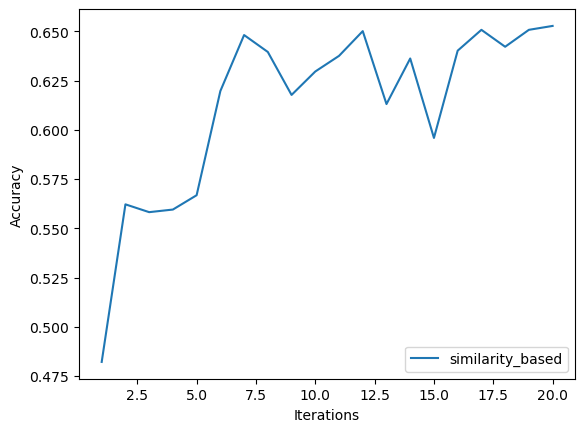

In [13]:
from transformers import ViTFeatureExtractor, ViTModel

for criterion in selection_criteria:
    AL_class = ActiveLearningPipeline(model=model,
                                      test_indices=test_indices,
                                      available_pool_indices=available_pool_indices,
                                      train_indices=train_indices,
                                      selection_criterion=criterion,
                                      iterations=iterations,
                                      budget_per_iter=budget_per_iter,
                                      num_epochs=num_epoch)
    accuracy_scores_dict[criterion] = AL_class.run_pipeline()
generate_plot(accuracy_scores_dict)

In [14]:
accuracy_scores_dict

defaultdict(list,
            {'similarity_based': [0.4821428571428571,
              0.5621693121693121,
              0.5582010582010581,
              0.5595238095238095,
              0.5667989417989417,
              0.6197089947089947,
              0.6481481481481481,
              0.6395502645502645,
              0.6177248677248677,
              0.6296296296296295,
              0.6375661375661376,
              0.6501322751322751,
              0.613095238095238,
              0.6362433862433862,
              0.5958994708994708,
              0.6402116402116402,
              0.6507936507936507,
              0.6421957671957672,
              0.6507936507936507,
              0.6527777777777778]})